In [57]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split, cross_val_score
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline, FunctionTransformer
import types
import seaborn as sns
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from lib.classifier import NaiveBayesClassifier

from sklearn.preprocessing import MinMaxScaler
from functools import cache
from scipy import signal
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
np.set_printoptions(precision=6, suppress=True)

In [2]:
# pip install scikeras[tensorflow]

In [55]:
    
def display_results(labels_test,rfc_pred):
    acc = accuracy_score(labels_test, rfc_pred)
    f1 = f1_score(labels_test, rfc_pred, average='macro')
    print(classification_report(labels_test,rfc_pred, digits=4))

    aux_df = labels_test.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

@cache
def transform_channel_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def transform_data_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def umap_transform_channel_per_channel(array_name:str,umap):
    array = globals()[array_name]
    transform_list = []
    for channel in range(64):
        transform_list.append(umap.transform(array[:,channel,:]).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list

@cache
def transform_channel_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_channel_per_event(array_name,pca))

@cache
def transform_data_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_data_per_event(array_name,pca))

@cache
def transform_csp(array_name:str,csp):
    array = globals()[array_name]
    return csp.transform(array)

@cache
def concat_channels(array_name:str):
    array = globals()[array_name]
    list_array = []
    for event in array:
        list_array.append(np.concatenate(event))
    return np.vstack(list_array)

@cache
def transform_all_concat(array_name:str,pca):
    return pca.transform(concat_channels(array_name))

@cache
def transform_channel_concat(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(np.concatenate(pca.transform(event.T)))
    transform_list = np.vstack(transform_list) 
    return transform_list

@cache
def transform_data_concat(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(np.concatenate(pca.transform(event).T))
    transform_list = np.vstack(transform_list) 
    return transform_list


def create_model(my_params):
    model = tf.keras.Sequential(my_params["layers"])
    model.compile(
        optimizer=my_params["optimizer"],
        loss=my_params["loss"],
        metrics=my_params["metrics"])
    return model

def butter_bandpass(lowcut,highcut,fs,order):
    nyq=0.5*fs
    low=lowcut/nyq
    high=highcut/nyq
    b,a = signal.butter(8,[low,high],'bandpass')
    return b,a
def butter_bandpass_filter(data,lowcut,highcut,fs,order):
    b,a=butter_bandpass(lowcut,highcut,fs,order)
    y=signal.filtfilt(b,a,data,axis=2)
    return y


@cache
def transform_FBCSP(array_name:str,csps_list_name:str,freq=[4,8,12,16,20,24,28,32,36,40]):
    array = globals()[array_name]
    csps = globals()[csps_list_name]
    features_test=[]
    for freq_count in range(len(freq)):
    #loop for freqency
        lower=freq[freq_count]
        if lower==freq[-1]:
            break
        csp=csps[freq_count]
        higher=freq[freq_count+1]
        X_test_filt=butter_bandpass_filter(array,lowcut=lower,highcut=higher,fs=128,order=8)
        tmp_test=csp.transform(X_test_filt)
        if freq_count==0:
            features_test=tmp_test
        else:
            features_test=np.concatenate((features_test,tmp_test),axis=1)
    return features_test

class Pipe:

    def __init__(self,name, model, processed_X_train,processed_X_val, adapter = None):
        self.name = name
        self.model = model
        self.processed_X_train = processed_X_train
        self.processed_X_val = processed_X_val
        if adapter is not None:
            self.adapter = FunctionTransformer(adapter)
        else:
            self.adapter = None
        
    def create_pipeline(self):
        if self.adapter is not None:
            return Pipeline([
                ('adapter', self.adapter),
                ('model', self.model)
            ])
        else:
            return Pipeline([
                ('model', self.model)
            ])


In [4]:
metrics = []
subjects_range = range(1, 10)
for subject in subjects_range:
    fileName = f'../../datasources/BCICIV_2a_gdf/A{subject:02d}T.gdf'

    if subject == subjects_range[0]:
        raw = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG-left', 'EOG-central', 'EOG-right'], verbose=0)
    else:
        new_raw = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG-left', 'EOG-central', 'EOG-right'], verbose=0)
        raw = mne.io.concatenate_raws([raw, new_raw])
            


c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Cha

In [5]:
raw_backup = raw.copy()

In [6]:
raw = raw_backup.copy()

In [7]:
names = {'EEG-Fz':'Fz',
 'EEG-0':'FC3',
 'EEG-1':'FC1',
 'EEG-2':'FCz',
 'EEG-3':'FC2',
 'EEG-4':'FC4',
 'EEG-5':'C5',
 'EEG-C3':'C3',
 'EEG-6':'C1',
 'EEG-Cz':'Cz',
 'EEG-7':'C2',
 'EEG-C4':'C4',
 'EEG-8':'C6',
 'EEG-9':'CP3',
 'EEG-10':'CP1',
 'EEG-11':'CPz',
 'EEG-12':'CP2',
 'EEG-13':'CP4',
 'EEG-14':'P1',
 'EEG-Pz':'Pz',
 'EEG-15':'P2',
 'EEG-16':'POz',
 'EOG-left':'EOG-left',
 'EOG-central':'EOG-central',
 'EOG-right':'EOG-right'}
raw.rename_channels(names)
raw.set_channel_types({channel:"eeg" for channel in raw.ch_names})

# Add positions to channels
mne.datasets.eegbci.standardize(raw)  # set channel names

montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage,on_missing ='warn')

raw.set_channel_types({'EOG-LEFT':'eog',
 'EOG-CENTRAL':'eog',
 'EOG-RIGHT':'eog'})

raw.annotations.rename({'769':"left", '770':"right"})

events = mne.events_from_annotations(raw)
# Apply band-pass filter
raw.filter(4.0, 40.0, fir_design="firwin", skip_by_annotation="edge")


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '771', '772', 'left', 'right']
Filtering raw data in 9 contiguous segments


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_14600\1342731742.py:33: RuntimeWarning: DigMontage is only a subset of info. There are 3 channel positions not present in the DigMontage. The channels missing from the montage are:

['EOG-LEFT', 'EOG-CENTRAL', 'EOG-RIGHT'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage,on_missing ='warn')


Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.5s finished


<RawGDF | A01T.gdf, 25 x 6005911 (24023.6 s), ~1.12 GB, data loaded>

In [8]:
# raw.load_data()
# raw.set_eeg_reference("average")
# eog_epochs = mne.preprocessing.create_eog_epochs(raw, l_freq=5.0, h_freq=42)
# # We need to explicitly specify that we want to average the EOG channel too.
# eog_evoked = eog_epochs.average("all")

# model_evoked = mne.preprocessing.EOGRegression(picks="eeg", picks_artifact="eog").fit(eog_evoked)
# raw_clean = model_evoked.apply(raw)

raw_clean = raw


In [9]:
raw_clean.drop_channels(['EOG-LEFT', 'EOG-CENTRAL', 'EOG-RIGHT'])
picks = mne.pick_types(raw_clean.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
tmin, tmax = -1.0, 4.0


epochs = mne.Epochs(
    raw_clean,
    event_id=[7, 8],
    events = events[0],
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)


Not setting metadata
1296 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1296 events and 1251 original time points ...
0 bad epochs dropped


In [33]:


# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.

# The fixation cue start seems to be the event start, which takes 1,25 seconds. Removing 2 seconds from start for task assimilation. The event takes 6s +- 1s, to avoid adaptation, but the BCI only takes 3s.

epochs_train = epochs.copy().crop(tmin=2.0, tmax=4.0)
# epochs_train = epochs.copy().crop(tmin=0.5, tmax=2.5)

labels = epochs.events[:, -1] - 7

In [34]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()


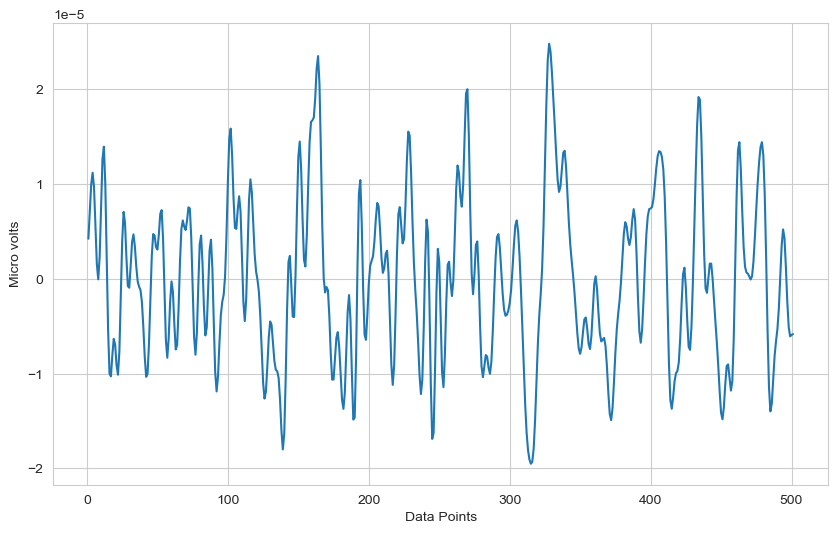

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(epochs_data_train[0][0])+1))
ax.plot(eixo_x, epochs_data_train[0][0])
ax.set_xlabel("Data Points")
ax.set_ylabel("Micro volts")
plt.show()

In [36]:
epochs_data_train.shape
# Number of events , channels, each measurement (f*t)

(1296, 22, 501)

In [37]:
list_array = []
for epoch in epochs_data_train:
    list_array.append((epoch - np.min(epoch))/(np.max(epoch)-np.min(epoch)))
epochs_data_train_normalized = np.array(list_array)

In [38]:
epochs_data_train_normalized.shape

(1296, 22, 501)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(epochs_data_train, labels, test_size=0.3,shuffle = False, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(epochs_data_train_normalized, labels, test_size=0.3,shuffle = False, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2,shuffle = False, random_state=42)


In [40]:
concat_X_train = concat_channels("X_train")

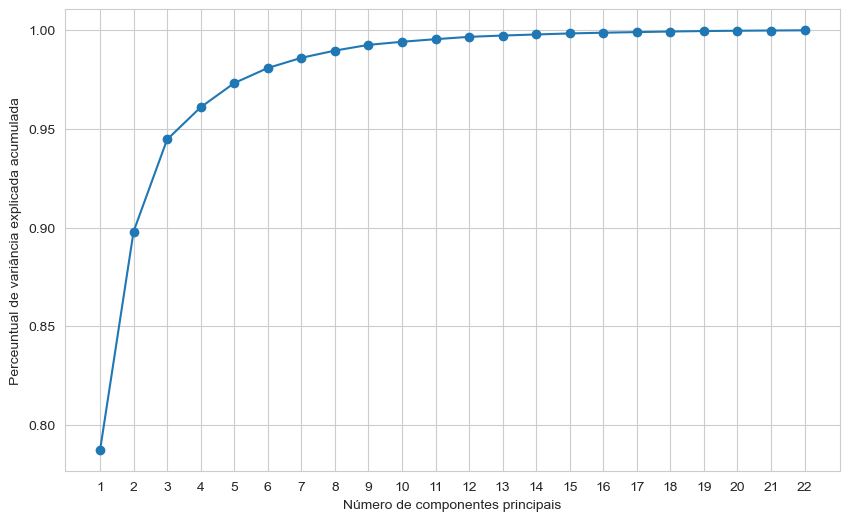

[0.787145 0.898039 0.944682 0.961023 0.973256 0.9809   0.986059 0.98972
 0.992621 0.994193 0.995509 0.996691 0.997349 0.997897 0.998412 0.998791
 0.9991   0.999388 0.999635 0.999784 0.999903 1.      ] 0.9897203647782845


In [65]:
pca_channel = PCA(random_state=42,)
for event in X_train:
    pca_channel.fit(event.T)

variancia_explicada_acumulada_channel = np.cumsum(pca_channel.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel,variancia_explicada_acumulada_channel[8-1])

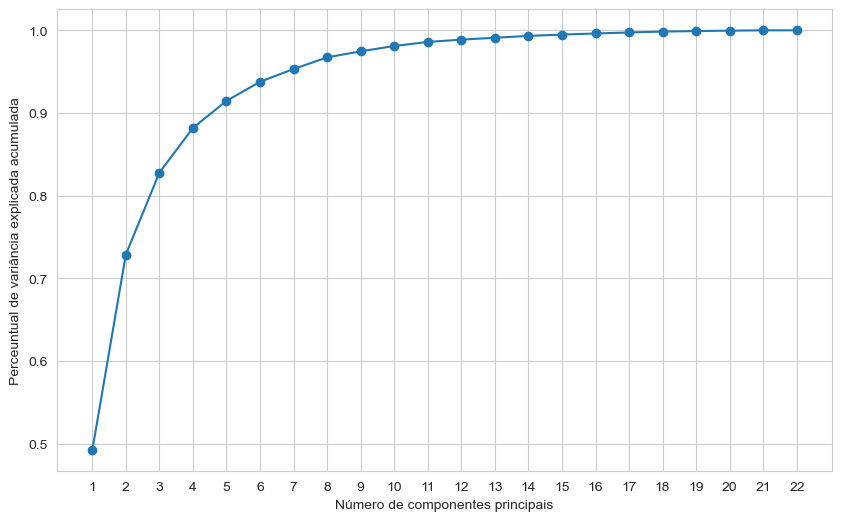

[0.491985 0.728784 0.827791 0.88197  0.914631 0.937733 0.953209 0.967258
 0.974616 0.980997 0.98596  0.988721 0.991019 0.993228 0.994854 0.99615
 0.997419 0.998457 0.999086 0.999588 1.       1.      ] 0.9746155134290203


In [66]:
pca_data = PCA(random_state=42,)
for event in X_train:
    pca_data.fit(event)

variancia_explicada_acumulada_data = np.cumsum(pca_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_data,variancia_explicada_acumulada_data[9-1])

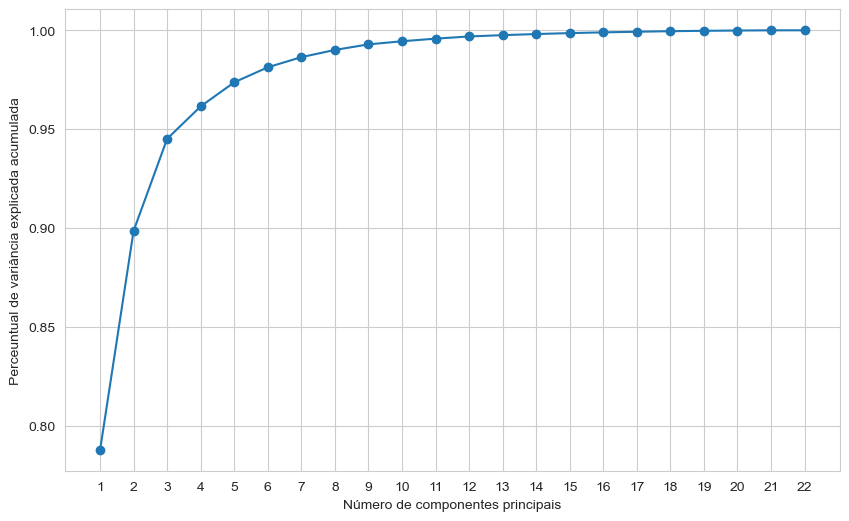

[0.787672 0.898615 0.945142 0.961558 0.97371  0.981313 0.986438 0.990076
 0.992893 0.994471 0.995793 0.996896 0.997555 0.998114 0.998594 0.998966
 0.999279 0.999555 0.999751 0.99989  1.       1.      ] 0.9900762586644524


In [67]:
pca_channel_data = PCA(random_state=42,)
for event in transform_channel_per_event("X_train",pca_channel):
    pca_channel_data.fit(event)

variancia_explicada_acumulada_channel_data = np.cumsum(pca_channel_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel_data,variancia_explicada_acumulada_channel_data[8-1])

In [68]:
pca_all = PCA(random_state=42,)

pca_all.fit(concat_X_train)

PCA(random_state=42)

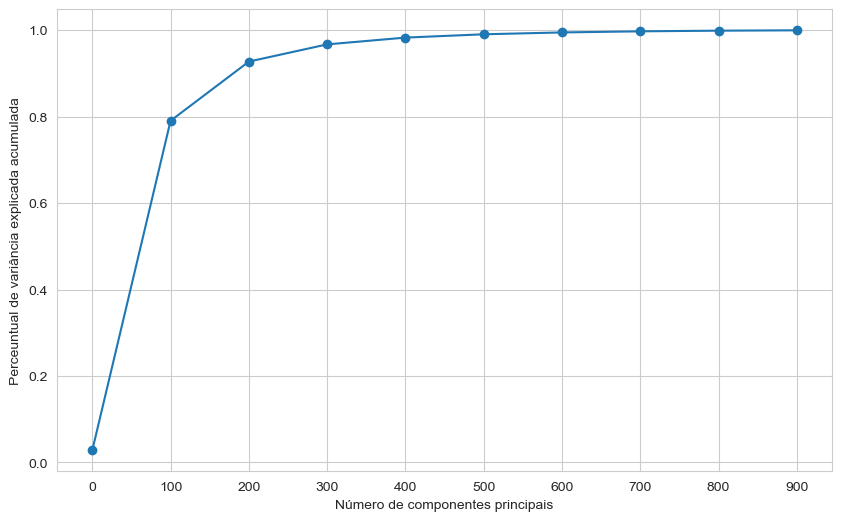

0.983025278971585


In [69]:

variancia_explicada_acumulada_all = np.cumsum(pca_all.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(0, len(variancia_explicada_acumulada_all)+1,100))
ax.plot(eixo_x, variancia_explicada_acumulada_all[0::100], marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_all[400-1])

In [70]:
del pca_all
del pca_data
del pca_channel_data
del pca_channel


In [71]:
del variancia_explicada_acumulada_all
del variancia_explicada_acumulada_channel
del variancia_explicada_acumulada_channel_data
del variancia_explicada_acumulada_data

In [41]:
num_pca_all = 400


In [42]:
# pca900_all = PCA(random_state=42,n_components=num_pca_all)
# pca900_all.fit(concat_X_train)

In [43]:
num_csp4 = 3
num_csp15 = 4
num_pca_data = 10
num_pca_channel = 15


In [137]:
pca12_channel = PCA(random_state=42,n_components=num_pca_channel)
for event in X_train:
    pca12_channel.fit(event.T)

In [138]:
pca16_data = PCA(random_state=42,n_components=num_pca_data)
for event in X_train:
    pca16_data.fit(event)

In [140]:
csp15 = mne.decoding.CSP(n_components=num_csp15, reg=None, log=True, norm_trace=False)
csp15.fit(X_train, y_train)

Computing rank from data with rank=None


    Using tolerance 7.3e-05 (2.2e-16 eps * 22 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-05 (2.2e-16 eps * 22 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [44]:

csp4 = mne.decoding.CSP(n_components=num_csp4, reg=None, log=True, norm_trace=False)
csp4.fit(X_train, y_train)

Computing rank from data with rank=None


    Using tolerance 7.7e-05 (2.2e-16 eps * 22 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-05 (2.2e-16 eps * 22 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [45]:
features_train=[]
features_test=[]
fbcsps = []
freq=[4,8,12,16,20,24,28,32,36,40]
for freq_count in range(len(freq)):
    csp=mne.decoding.CSP(n_components=2, reg=None, log=True, norm_trace=False)
    lower=freq[freq_count]
    if lower==freq[-1]:
        break
    higher=freq[freq_count+1]
    X_train_filt=butter_bandpass_filter(X_train,lowcut=lower,highcut=higher,fs=128,order=8)
    csp.fit(X_train_filt,y_train)
    fbcsps.append(csp)

Computing rank from data with rank=None
    Using tolerance 4.5e-05 (2.2e-16 eps * 22 dim * 9.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-05 (2.2e-16 eps * 22 dim * 9.7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e-05 (2.2e-16 eps * 22 dim * 5.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e-05 (2.2e-16 eps * 22 dim * 5.2e+09  max singular value)


In [142]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp4 = mne.decoding.CSP(n_components=num_csp4, reg=None, log=True, norm_trace=False)
pca12_channel_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 5e-05 (2.2e-16 eps * 15 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 15
    MAG: rank 15 computed from 15 data channels with 0 projectors
Reducing data rank from 15 -> 15
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.1e-05 (2.2e-16 eps * 15 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 15
    MAG: rank 15 computed from 15 data channels with 0 projectors
Reducing data rank from 15 -> 15
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [143]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp15 = mne.decoding.CSP(n_components=num_csp15, reg=None, log=True, norm_trace=False)
pca12_channel_csp15.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 5e-05 (2.2e-16 eps * 15 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 15
    MAG: rank 15 computed from 15 data channels with 0 projectors
Reducing data rank from 15 -> 15
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.1e-05 (2.2e-16 eps * 15 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 15
    MAG: rank 15 computed from 15 data channels with 0 projectors
Reducing data rank from 15 -> 15
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [144]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp4 = mne.decoding.CSP(n_components=num_csp4, reg=None, log=True, norm_trace=False)
pca16_data_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 4.3e-05 (2.2e-16 eps * 22 dim * 8.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-05 (2.2e-16 eps * 22 dim * 8.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [145]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp15 = mne.decoding.CSP(n_components=num_csp15, reg=None, log=True, norm_trace=False)
pca16_data_csp15.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 4.3e-05 (2.2e-16 eps * 22 dim * 8.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-05 (2.2e-16 eps * 22 dim * 8.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [146]:
# umap15_unsup = UMAP(n_components=15,random_state=42,n_neighbors=30,min_dist=0.05)
# umap15_unsup.fit(X_train[:,0,:])

In [147]:
# umap15 = UMAP(n_components=16,random_state=42,n_neighbors=30,min_dist=0.05)
# for channel in range(64):
#     umap15.fit(X_train[:,channel,:],y_train)

In [148]:
# a = umap15.transform(X_val[:,0,:])
# fig, ax = plt.subplots()
# sns.scatterplot(ax = ax, x = a[:,0],y=  a[:,1], hue =  y_val,palette="tab10")
# ax.set_ylabel("Segunda componente")
# ax.set_xlabel("Primeira Componente")
# ax.legend(["Classe","T0","T1","T2"])
# ax.set_xticks(list(range(3, 6+1))) 
# ax.set_yticks(list(range(-2, 2+1)))
# plt.show()

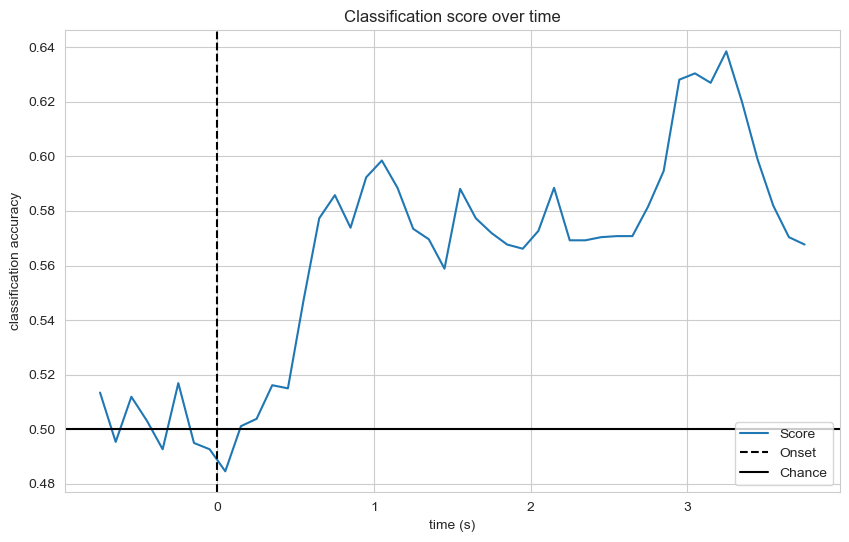

In [46]:
epochs_data_local = epochs.get_data()
epochs_data_train_local = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train_local)
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data_local.shape[2] - w_length, w_step)
lda = LinearDiscriminantAnalysis()

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train_local, y_test_local = labels[train_idx], labels[test_idx]

    X_train_local = csp4.transform(epochs_data_train_local[train_idx])

    # fit classifier
    lda.fit(X_train_local, y_train_local)

cv_split = cv.split(epochs_data_train_local)

for train_idx, test_idx in cv_split:
    y_train_local, y_test_local = labels[train_idx], labels[test_idx]
    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test_local = csp4.transform(epochs_data_local[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test_local, y_test_local))
    scores_windows.append(score_this_window)


# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [150]:
X_train.shape

(907, 22, 501)

In [151]:
transform_csp("X_train",csp4).shape

(907, 3)

In [58]:
#Get Indices (it's the same for all, as suffle is False by default)
pipe = Pipe("lda_csp4",NaiveBayesClassifier(bandwidth=1,kernel='radial'),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
pipeline = pipe.create_pipeline()
cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True,return_indices=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

print(f"Results for pipeline with {pipe.name}:")
print("----------------")
print("Test accuracy scores:", cv_results['test_Accuracy'])
print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
print("-----")
print("Test F1 scores:", cv_results['test_F1'])
print("Mean test F1:", cv_results['test_F1'].mean())
print("----------------")
print("train accuracy scores:", cv_results['train_Accuracy'])
print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
print("-----")
print("train F1 scores:", cv_results['train_F1'])
print("Mean train F1:", cv_results['train_F1'].mean())
print("----------------")
print("Fit time:", cv_results['fit_time'])
print("Score time:", cv_results['score_time'])
print()
print("--------------------------------------------------------------------------------------------")

indices = cv_results["indices"]["test"]

Results for pipeline with lda_csp4:
----------------
Test accuracy scores: [0.659341 0.703297 0.681319 0.736264 0.648352 0.637363 0.637363 0.522222
 0.655556 0.588889]
Mean test accuracy: 0.646996336996337
-----
Test F1 scores: [0.657853 0.700986 0.657495 0.730769 0.628571 0.628571 0.635779 0.488839
 0.642811 0.584736]
Mean test F1: 0.6356412148799319
----------------
train accuracy scores: [0.954657 0.953431 0.943627 0.947304 0.95098  0.960784 0.959559 0.95104
 0.946144 0.95104 ]
Mean train accuracy: 0.9518568351453187
-----
train F1 scores: [0.954637 0.953429 0.943624 0.947294 0.95097  0.960783 0.959554 0.951028
 0.946126 0.951014]
Mean train F1: 0.9518460000775887
----------------
Fit time: [0.001001 0.       0.       0.       0.       0.000999 0.       0.001
 0.000999 0.001   ]
Score time: [0.012024 0.013    0.011998 0.014019 0.012026 0.013    0.012998 0.013
 0.014999 0.014999]

--------------------------------------------------------------------------------------------


In [153]:
def aff(array):
    X_std = (array - np.min(array)) / (np.max(array) - np.min(array))
    X_scaled = X_std * (1-0)+0
    return X_scaled

### Not runned MLP

In [ ]:
# MLP_plain = Pipe("MLP_plain",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),concat_channels("X_train")) - Takes too long
MLP_csp4 = Pipe("MLP_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
MLP_csp15 = Pipe("MLP_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
MLP_pca12_channel = Pipe("MLP_pca12_channel",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
MLP_pca16_data = Pipe("MLP_pca16_data",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # # # MLP_pca900_all = Pipe("MLP_pca900_all",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
MLP_pca12_channel_csp4 = Pipe("MLP_pca12_channel_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
MLP_pca16_data_csp4 = Pipe("MLP_pca16_data_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
MLP_pca12_channel_csp15 = Pipe("MLP_pca12_channel_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
MLP_pca16_data_csp15 = Pipe("MLP_pca16_data_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
Keras_MLP_csp4 = Pipe("Keras_MLP_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
Keras_MLP_csp15 = Pipe("Keras_MLP_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp15),transform_csp("X_val",csp15))

Keras_MLP_pca12_channel = Pipe("Keras_MLP_pca12_channel",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_concat("X_train",pca12_channel).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
Keras_MLP_pca16_data = Pipe("Keras_MLP_pca16_data",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_concat("X_train",pca16_data).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # Keras_MLP_pca900_all = Pipe("Keras_MLP_pca900_all",KerasClassifier(model=create_model, my_params={
        # "layers":[
        #     # tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_all_concat("X_train",pca900_all).shape[1],)),
        #     tf.keras.layers.Dense(20, activation='sigmoid'),
        #     tf.keras.layers.Dropout(0.5,seed= 42),
        #     tf.keras.layers.Dense(20, activation='sigmoid'),
        #     tf.keras.layers.Dropout(0.5,seed= 42),
        #     tf.keras.layers.Dense(10, activation='sigmoid'),
        #     tf.keras.layers.Dense(5, activation='sigmoid'),
        #     tf.keras.layers.Dense(3, activation='softmax')
        # ],
        # "optimizer":'adam',
        # "loss": 'sparse_categorical_crossentropy',
        # "metrics": ['accuracy']
    # # }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))



Keras_MLP_pca16_data_csp4 = Pipe("Keras_MLP_pca16_data_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
Keras_MLP_pca12_channel_csp4 = Pipe("Keras_MLP_pca12_channel_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
Keras_MLP_pca16_data_csp15 = Pipe("Keras_MLP_pca16_data_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
Keras_MLP_pca12_channel_csp15 = Pipe("Keras_MLP_pca12_channel_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))



### Runned Models

In [154]:
# lda_plain = Pipe("lda_csp4",LinearDiscriminantAnalysis(),concat_channels("X_train") ) - Takes too long
lda_csp4 = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
lda_csp15 = Pipe("lda_csp15",LinearDiscriminantAnalysis(),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
lda_pca12_channel_csp4 = Pipe("lda_pca12_channel_csp4",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
lda_pca16_data_csp4 = Pipe("lda_pca16_data_csp4",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# lda_pca900_all = Pipe("lda_pca900_all",LinearDiscriminantAnalysis(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
lda_pca12_channel = Pipe("lda_pca12_channel",LinearDiscriminantAnalysis(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
lda_pca16_data = Pipe("lda_pca16_data",LinearDiscriminantAnalysis(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
lda_pca12_channel_csp15 = Pipe("lda_pca12_channel_csp15",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
lda_pca16_data_csp15 = Pipe("lda_pca16_data_csp15",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# mnbc_plain = Pipe("mnbc_plain",MultinomialNB(),concat_channels("X_train"),aff)
mnbc_csp4 = Pipe("mnbc_csp4",MultinomialNB(),transform_csp("X_train",csp4),transform_csp("X_val",csp4),aff)
mnbc_csp15 = Pipe("mnbc_csp15",MultinomialNB(),transform_csp("X_train",csp15),transform_csp("X_val",csp15),aff)
mnbc_pca12_channel = Pipe("mnbc_pca12_channel",MultinomialNB(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel),aff)
mnbc_pca16_data = Pipe("mnbc_pca16_data",MultinomialNB(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data),aff)
# # # # mnbc_pca900_all = Pipe("mnbc_pca900_all",MultinomialNB(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all),aff)
mnbc_pca12_channel_csp4 = Pipe("mnbc_pca12_channel_csp4",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4),aff)
mnbc_pca16_data_csp4 = Pipe("mnbc_pca16_data_csp4",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4),aff)
mnbc_pca12_channel_csp15 = Pipe("mnbc_pca12_channel_csp15",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15),aff)
mnbc_pca16_data_csp15 = Pipe("mnbc_pca16_data_csp15",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15),aff)




Pipes = [
    lda_csp4,
    lda_csp15,
    lda_pca12_channel_csp4,
    lda_pca16_data_csp4,
    # lda_pca900_all,
    lda_pca12_channel,
    lda_pca16_data,
    lda_pca12_channel_csp15,
    lda_pca16_data_csp15,
    # mnbc_plain,
    mnbc_csp4,
    mnbc_csp15,
    mnbc_pca12_channel,
    mnbc_pca16_data,
    # mnbc_pca900_all,
    mnbc_pca12_channel_csp4,
    mnbc_pca16_data_csp4,
    mnbc_pca12_channel_csp15,
    mnbc_pca16_data_csp15,
    # MLP_plain,
    # MLP_csp4,
    # MLP_csp15,
    # MLP_pca12_channel,
    # MLP_pca16_data,
    # MLP_pca900_all,
    # MLP_pca12_channel_csp4,
    # MLP_pca16_data_csp4,
    # MLP_pca12_channel_csp15,
    # MLP_pca16_data_csp15,
    # Keras_MLP_csp4,
    # Keras_MLP_csp15,
    # Keras_MLP_pca12_channel,
    # Keras_MLP_pca16_data,
    # Keras_MLP_pca900_all,
    # Keras_MLP_pca16_data_csp4,
    # Keras_MLP_pca12_channel_csp4,
    # Keras_MLP_pca16_data_csp15,
    # Keras_MLP_pca12_channel_csp15,
    
    
    
]


In [155]:
# results = {}
# for pipe in Pipes:
#     print(pipe.name)
#     # Create pipeline with the given pipe
#     pipeline = pipe.create_pipeline()
    
#     # Perform cross-validation
#     cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

#     print(f"Results for pipeline with {pipe.name}:")
#     print("----------------")
#     print("Test accuracy scores:", cv_results['test_Accuracy'])
#     print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
#     print("-----")
#     print("Test F1 scores:", cv_results['test_F1'])
#     print("Mean test F1:", cv_results['test_F1'].mean())
#     print("----------------")
#     print("train accuracy scores:", cv_results['train_Accuracy'])
#     print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
#     print("-----")
#     print("train F1 scores:", cv_results['train_F1'])
#     print("Mean train F1:", cv_results['train_F1'].mean())
#     print("----------------")
#     print("Fit time:", cv_results['fit_time'])
#     print("Score time:", cv_results['score_time'])
#     print()
#     print("--------------------------------------------------------------------------------------------")

#     results[pipe.name] = (cv_results)


In [156]:
# for key, value in results.items(): 
#     print(value['test_Accuracy'])
#     print(",")
# for key, value in results.items(): 
#     print(np.mean(value['test_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(np.max(value['test_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(value['test_F1'])
#     print(",")
# for key, value in results.items(): 
#     print(value['train_Accuracy'])
#     print(",")
# for key, value in results.items(): 
#     print(np.mean(value['train_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(np.max(value['train_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(value['train_F1'])
#     print(",")
# for key, value in results.items(): 
#     print(value['fit_time'])
#     print(",")
# for key, value in results.items(): 
#     print(value['score_time'])
#     print(",")

In [183]:
# lda_plain = Pipe("lda_csp4",LinearDiscriminantAnalysis(),concat_channels("X_train") ) - Takes too long
lda_csp4 = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
lda_csp15 = Pipe("lda_csp15",LinearDiscriminantAnalysis(),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
lda_pca12_channel_csp4 = Pipe("lda_pca12_channel_csp4",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
lda_pca16_data_csp4 = Pipe("lda_pca16_data_csp4",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# lda_pca900_all = Pipe("lda_pca900_all",LinearDiscriminantAnalysis(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
lda_pca12_channel = Pipe("lda_pca12_channel",LinearDiscriminantAnalysis(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
lda_pca16_data = Pipe("lda_pca16_data",LinearDiscriminantAnalysis(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
lda_pca12_channel_csp15 = Pipe("lda_pca12_channel_csp15",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
lda_pca16_data_csp15 = Pipe("lda_pca16_data_csp15",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# mnbc_plain = Pipe("mnbc_plain",MultinomialNB(),concat_channels("X_train"),aff)
mnbc_csp4 = Pipe("mnbc_csp4",MultinomialNB(),transform_csp("X_train",csp4),transform_csp("X_val",csp4),aff)
mnbc_csp15 = Pipe("mnbc_csp15",MultinomialNB(),transform_csp("X_train",csp15),transform_csp("X_val",csp15),aff)
mnbc_pca12_channel = Pipe("mnbc_pca12_channel",MultinomialNB(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel),aff)
mnbc_pca16_data = Pipe("mnbc_pca16_data",MultinomialNB(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data),aff)
# # mnbc_pca900_all = Pipe("mnbc_pca900_all",MultinomialNB(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all),aff)
mnbc_pca12_channel_csp4 = Pipe("mnbc_pca12_channel_csp4",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4),aff)
mnbc_pca16_data_csp4 = Pipe("mnbc_pca16_data_csp4",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4),aff)
mnbc_pca12_channel_csp15 = Pipe("mnbc_pca12_channel_csp15",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15),aff)
mnbc_pca16_data_csp15 = Pipe("mnbc_pca16_data_csp15",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15),aff)
# MLP_plain = Pipe("MLP_plain",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),concat_channels("X_train")) - Takes too long
MLP_csp4 = Pipe("MLP_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
MLP_csp15 = Pipe("MLP_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
MLP_pca12_channel = Pipe("MLP_pca12_channel",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
MLP_pca16_data = Pipe("MLP_pca16_data",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # MLP_pca900_all = Pipe("MLP_pca900_all",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
MLP_pca12_channel_csp4 = Pipe("MLP_pca12_channel_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
MLP_pca16_data_csp4 = Pipe("MLP_pca16_data_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
MLP_pca12_channel_csp15 = Pipe("MLP_pca12_channel_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
MLP_pca16_data_csp15 = Pipe("MLP_pca16_data_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
Keras_MLP_csp4 = Pipe("Keras_MLP_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp4).shape[1],)),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=800, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
Keras_MLP_csp15 = Pipe("Keras_MLP_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp15).shape[1],)),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=800, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp15),transform_csp("X_val",csp15))

Keras_MLP_pca12_channel = Pipe("Keras_MLP_pca12_channel",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_concat("X_train",pca12_channel).shape[1],)),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=800, batch_size=32, verbose=0,random_state=42),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
Keras_MLP_pca16_data = Pipe("Keras_MLP_pca16_data",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_concat("X_train",pca16_data).shape[1],)),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=800, batch_size=32, verbose=0,random_state=42),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # Keras_MLP_pca900_all = Pipe("Keras_MLP_pca900_all",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_all_concat("X_train",pca900_all).shape[1],)),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     # }, epochs=800, batch_size=32, verbose=0,random_state=42),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))



Keras_MLP_pca16_data_csp4 = Pipe("Keras_MLP_pca16_data_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4).shape[1],)),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=800, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
Keras_MLP_pca12_channel_csp4 = Pipe("Keras_MLP_pca12_channel_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4).shape[1],)),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=800, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
Keras_MLP_pca16_data_csp15 = Pipe("Keras_MLP_pca16_data_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15).shape[1],)),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=800, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
Keras_MLP_pca12_channel_csp15 = Pipe("Keras_MLP_pca12_channel_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1],)),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=800, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))




Pipes = [
    lda_csp4,
    lda_csp15,
    lda_pca12_channel_csp4,
    lda_pca12_channel_csp15,
    lda_pca16_data_csp4,
    lda_pca16_data_csp15,
    # mnbc_plain,
    mnbc_csp4,
    mnbc_csp15,
    mnbc_pca12_channel_csp4,
    mnbc_pca12_channel_csp15,
    mnbc_pca16_data_csp4,
    mnbc_pca16_data_csp15,
    # MLP_plain,
    MLP_csp4,
    MLP_csp15,
    MLP_pca12_channel_csp4,
    MLP_pca12_channel_csp15,
    MLP_pca16_data_csp4,
    MLP_pca16_data_csp15,

    Keras_MLP_csp4,
    Keras_MLP_csp15,
    Keras_MLP_pca12_channel_csp4,
    Keras_MLP_pca12_channel_csp15,
    Keras_MLP_pca16_data_csp4,
    Keras_MLP_pca16_data_csp15,
    
    lda_pca12_channel,
    lda_pca16_data,
    # lda_pca900_all,
    mnbc_pca12_channel,
    mnbc_pca16_data,
    # mnbc_pca900_all,
    MLP_pca12_channel,
    MLP_pca16_data,
    # MLP_pca900_all,
    Keras_MLP_pca12_channel,
    Keras_MLP_pca16_data,
    # Keras_MLP_pca900_all,
    
    
]


In [184]:
results_val = {}
for pipe in Pipes:
    print(pipe.name)
    # Create pipeline with the given pipe
    pipeline = pipe.create_pipeline()
    
    # Perform cross-validation
    pipeline.fit( pipe.processed_X_train, y_train)
    train_score = pipeline.score(pipe.processed_X_train,y_train)
    val_score = pipeline.score(pipe.processed_X_val,y_val)


    print(f"Results for pipeline with {pipe.name}:")
    print("----------------")
    print("Test accuracy scores:", val_score)
    print("----------------")
    print("train accuracy scores:", train_score)
    print()
    print("--------------------------------------------------------------------------------------------")

    results_val[pipe.name] = (pipeline)


lda_csp4
Results for pipeline with lda_csp4:
----------------
Test accuracy scores: 0.6272493573264781
----------------
train accuracy scores: 0.6185226019845645

--------------------------------------------------------------------------------------------
lda_csp15
Results for pipeline with lda_csp15:
----------------
Test accuracy scores: 0.5784061696658098
----------------
train accuracy scores: 0.6405733186328556

--------------------------------------------------------------------------------------------
lda_pca12_channel_csp4
Results for pipeline with lda_pca12_channel_csp4:
----------------
Test accuracy scores: 0.6272493573264781
----------------
train accuracy scores: 0.5810363836824697

--------------------------------------------------------------------------------------------
lda_pca12_channel_csp15
Results for pipeline with lda_pca12_channel_csp15:
----------------
Test accuracy scores: 0.6169665809768637
----------------
train accuracy scores: 0.6030871003307607

---------

lda_csp4
              precision    recall  f1-score   support

           5     0.7232    0.4154    0.5277       195
           6     0.5884    0.8402    0.6921       194

    accuracy                         0.6272       389
   macro avg     0.6558    0.6278    0.6099       389
weighted avg     0.6560    0.6272    0.6097       389



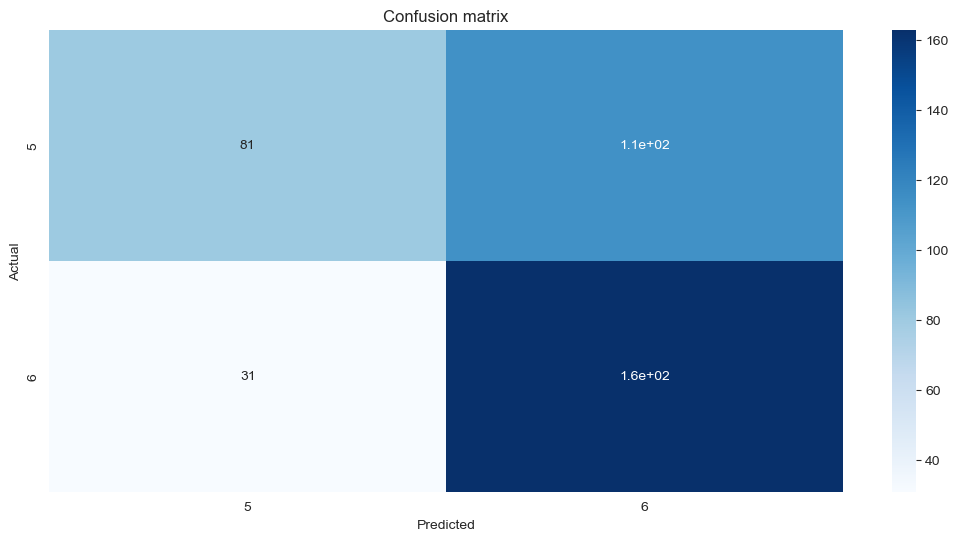

lda_csp15
              precision    recall  f1-score   support

           5     0.7067    0.2718    0.3926       195
           6     0.5478    0.8866    0.6772       194

    accuracy                         0.5784       389
   macro avg     0.6272    0.5792    0.5349       389
weighted avg     0.6274    0.5784    0.5345       389



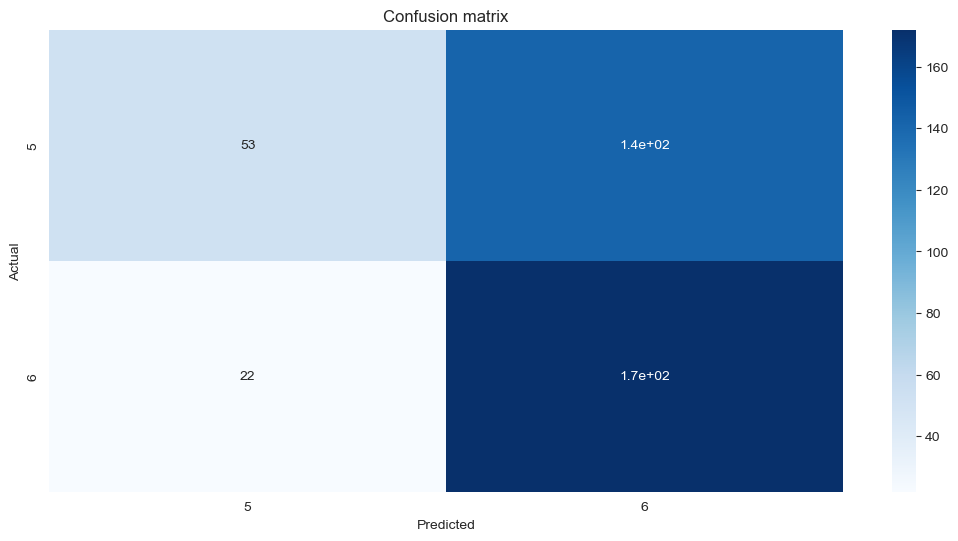

lda_pca12_channel_csp4
              precision    recall  f1-score   support

           5     0.6984    0.4513    0.5483       195
           6     0.5932    0.8041    0.6827       194

    accuracy                         0.6272       389
   macro avg     0.6458    0.6277    0.6155       389
weighted avg     0.6459    0.6272    0.6153       389



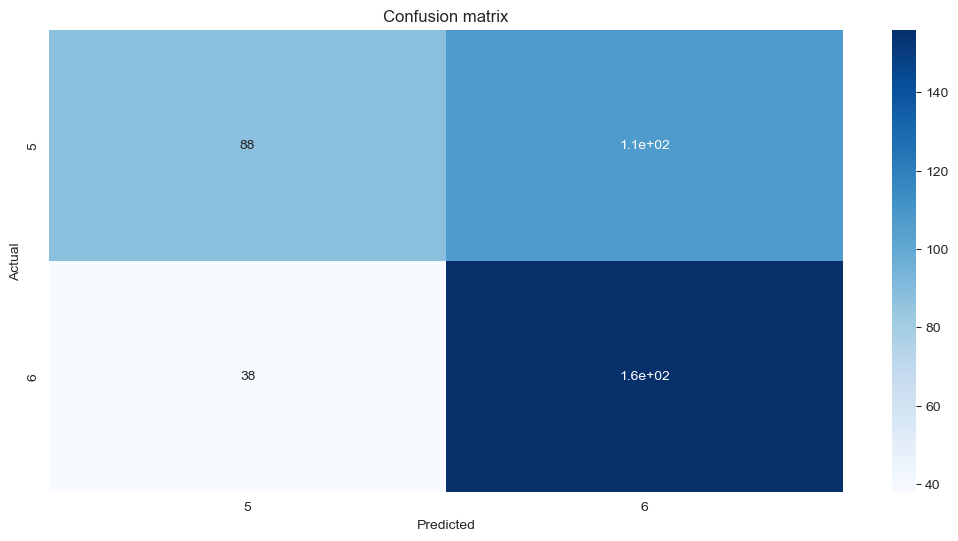

lda_pca12_channel_csp15
              precision    recall  f1-score   support

           5     0.6620    0.4821    0.5579       195
           6     0.5911    0.7526    0.6621       194

    accuracy                         0.6170       389
   macro avg     0.6265    0.6173    0.6100       389
weighted avg     0.6266    0.6170    0.6099       389



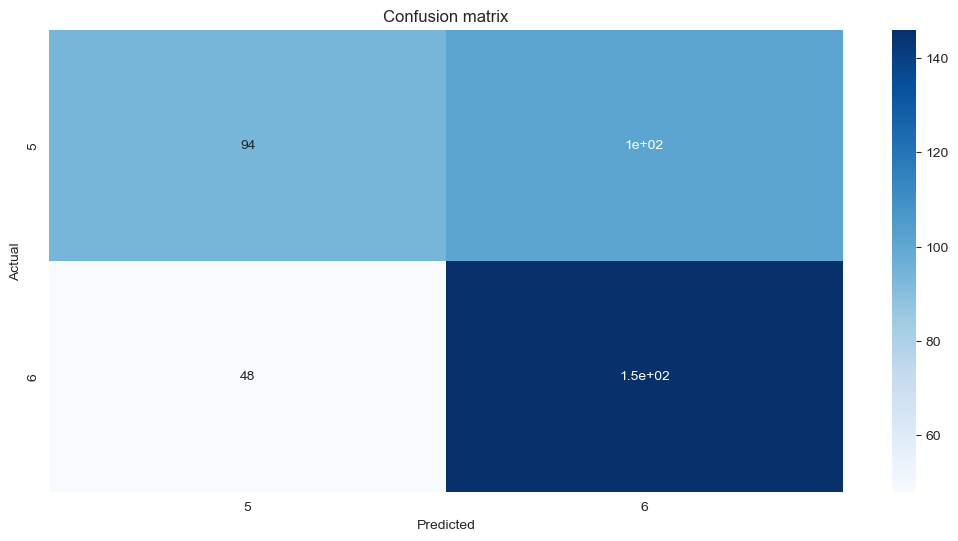

lda_pca16_data_csp4
              precision    recall  f1-score   support

           5     0.5244    0.2205    0.3105       195
           6     0.5049    0.7990    0.6188       194

    accuracy                         0.5090       389
   macro avg     0.5146    0.5097    0.4646       389
weighted avg     0.5147    0.5090    0.4642       389



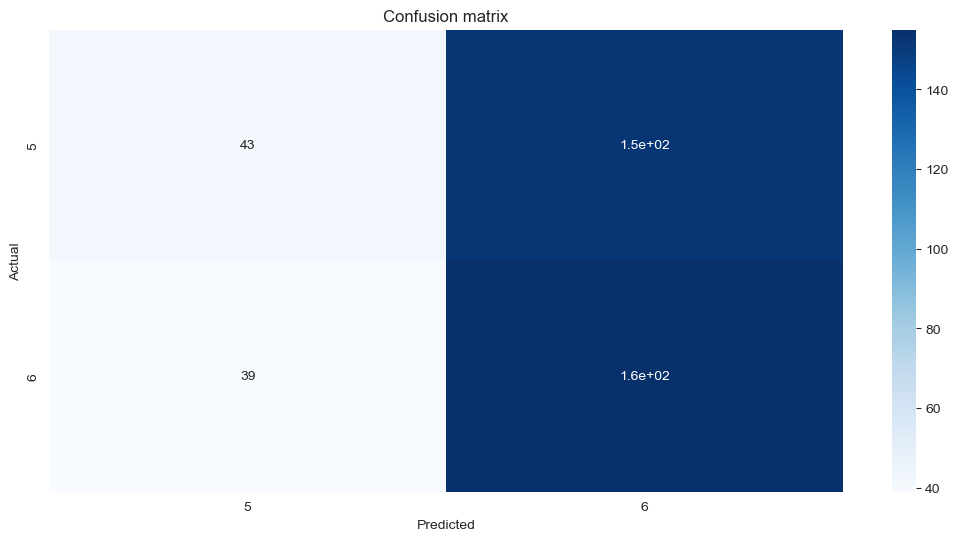

lda_pca16_data_csp15
              precision    recall  f1-score   support

           5     0.5693    0.4000    0.4699       195
           6     0.5357    0.6959    0.6054       194

    accuracy                         0.5476       389
   macro avg     0.5525    0.5479    0.5376       389
weighted avg     0.5526    0.5476    0.5375       389



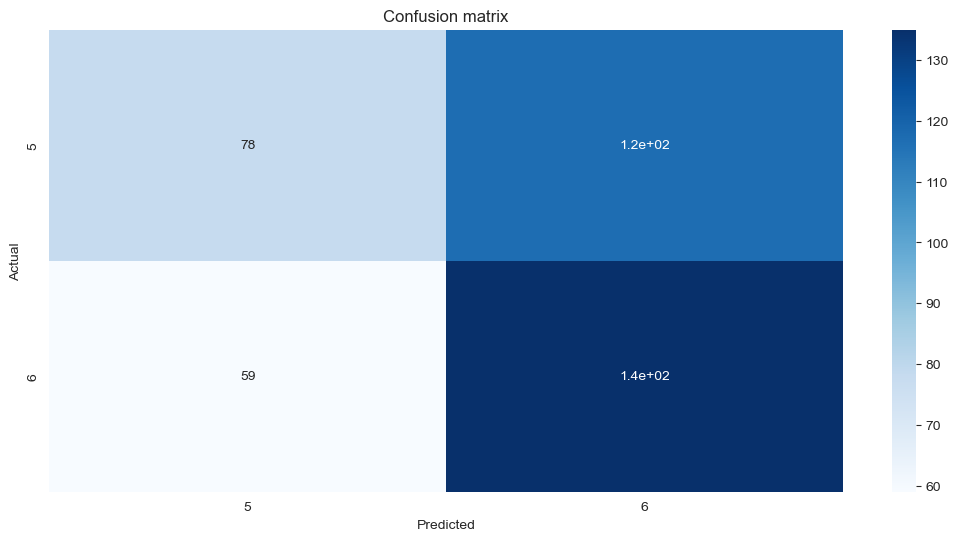

mnbc_csp4
              precision    recall  f1-score   support

           5     0.6923    0.3231    0.4406       195
           6     0.5570    0.8557    0.6748       194

    accuracy                         0.5887       389
   macro avg     0.6247    0.5894    0.5577       389
weighted avg     0.6249    0.5887    0.5574       389



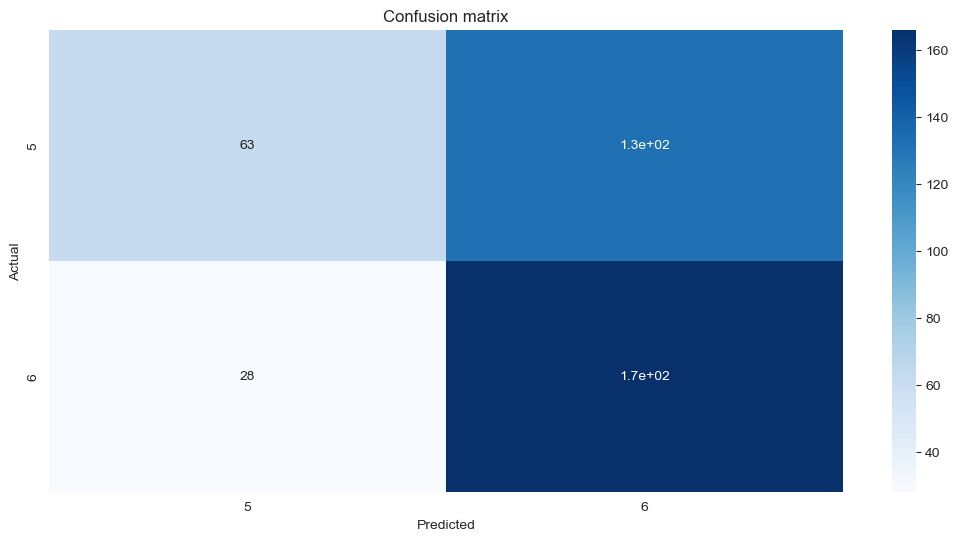

mnbc_csp15
              precision    recall  f1-score   support

           5     0.6800    0.2615    0.3778       195
           6     0.5414    0.8763    0.6693       194

    accuracy                         0.5681       389
   macro avg     0.6107    0.5689    0.5235       389
weighted avg     0.6109    0.5681    0.5232       389



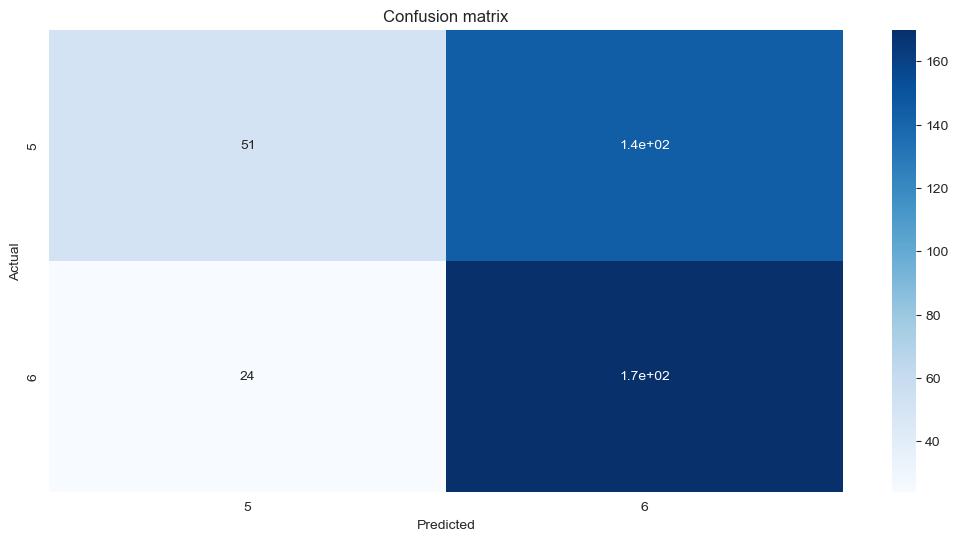

mnbc_pca12_channel_csp4
              precision    recall  f1-score   support

           5     0.7283    0.3436    0.4669       195
           6     0.5690    0.8711    0.6884       194

    accuracy                         0.6067       389
   macro avg     0.6486    0.6074    0.5776       389
weighted avg     0.6488    0.6067    0.5774       389



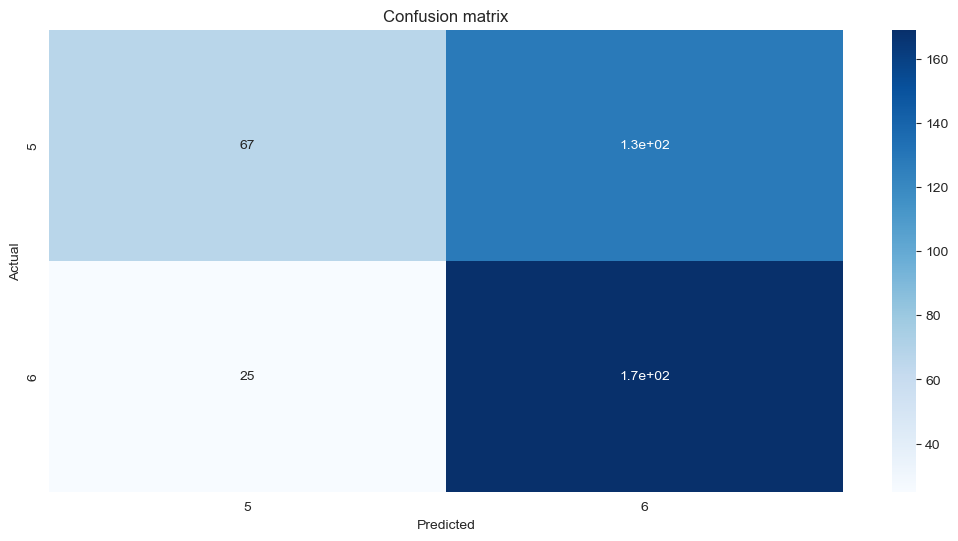

mnbc_pca12_channel_csp15
              precision    recall  f1-score   support

           5     0.7045    0.3179    0.4382       195
           6     0.5581    0.8660    0.6788       194

    accuracy                         0.5913       389
   macro avg     0.6313    0.5920    0.5585       389
weighted avg     0.6315    0.5913    0.5582       389



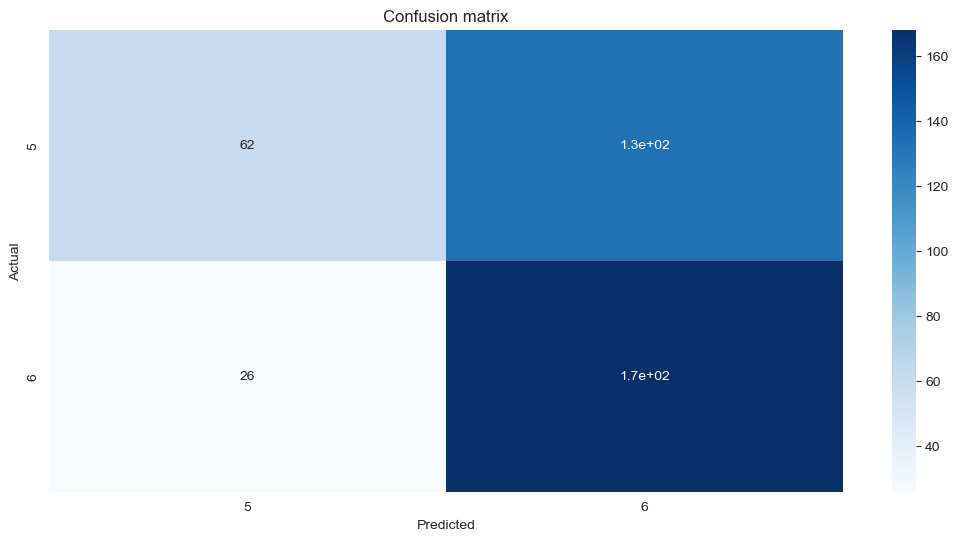

mnbc_pca16_data_csp4
              precision    recall  f1-score   support

           5     0.4286    0.2308    0.3000       195
           6     0.4718    0.6907    0.5607       194

    accuracy                         0.4602       389
   macro avg     0.4502    0.4607    0.4303       389
weighted avg     0.4501    0.4602    0.4300       389



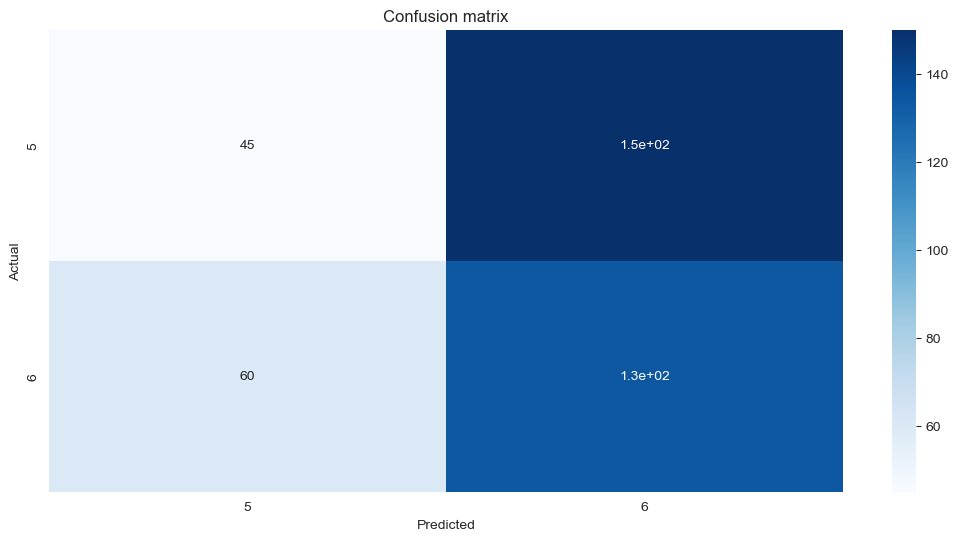

mnbc_pca16_data_csp15
              precision    recall  f1-score   support

           5     0.4926    0.3436    0.4048       195
           6     0.4941    0.6443    0.5593       194

    accuracy                         0.4936       389
   macro avg     0.4934    0.4940    0.4821       389
weighted avg     0.4934    0.4936    0.4819       389



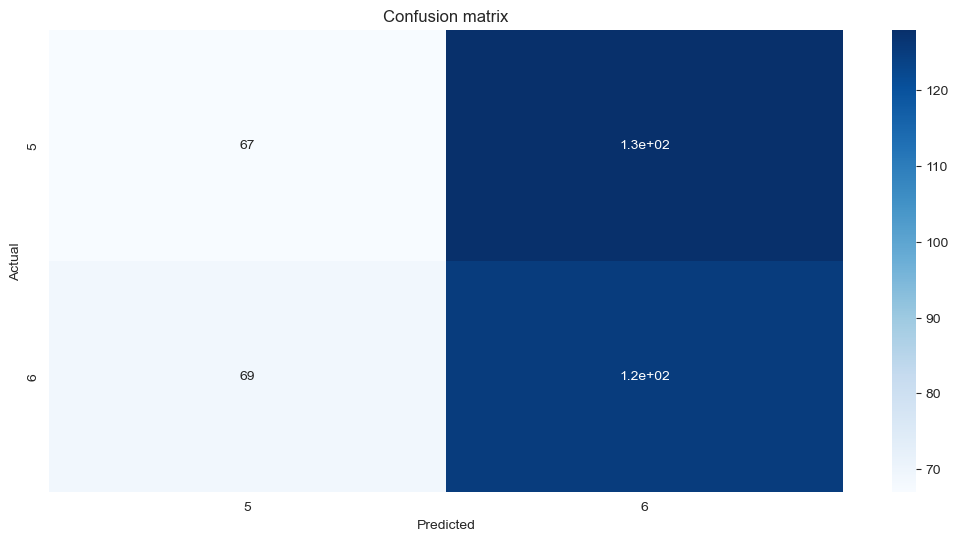

MLP_csp4
              precision    recall  f1-score   support

           5     0.5074    0.3538    0.4169       195
           6     0.5020    0.6546    0.5682       194

    accuracy                         0.5039       389
   macro avg     0.5047    0.5042    0.4926       389
weighted avg     0.5047    0.5039    0.4924       389



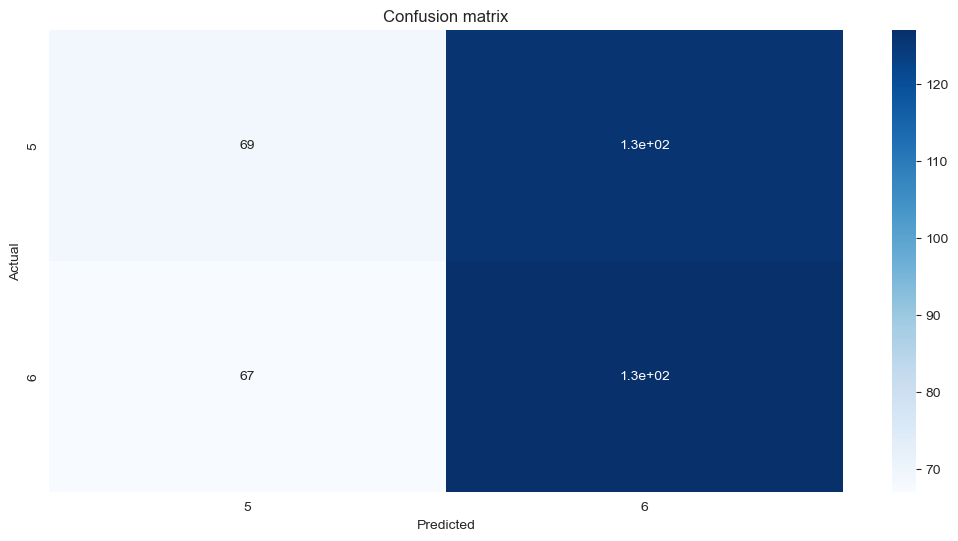

MLP_csp15
              precision    recall  f1-score   support

           5     0.5013    1.0000    0.6678       195
           6     0.0000    0.0000    0.0000       194

    accuracy                         0.5013       389
   macro avg     0.2506    0.5000    0.3339       389
weighted avg     0.2513    0.5013    0.3348       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


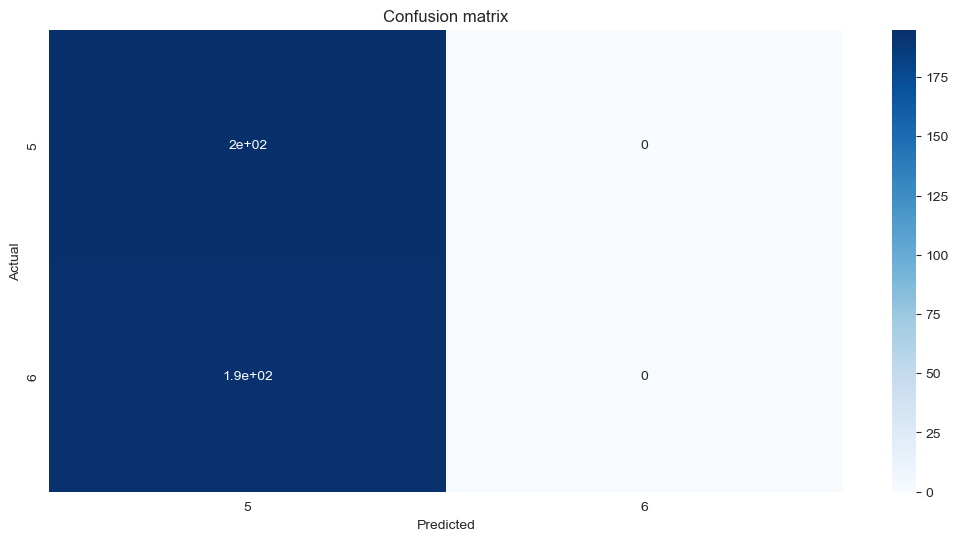

MLP_pca12_channel_csp4
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


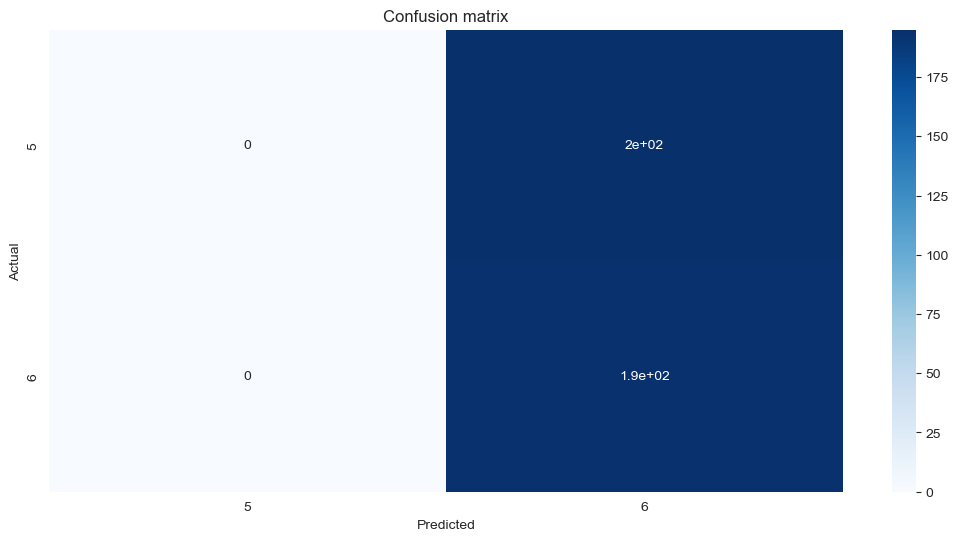

MLP_pca12_channel_csp15
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


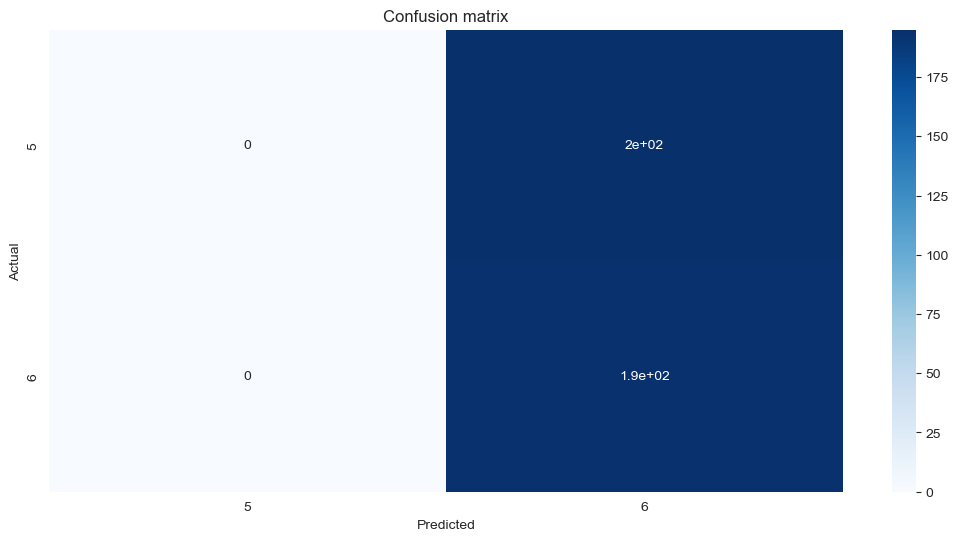

MLP_pca16_data_csp4
              precision    recall  f1-score   support

           5     0.5013    1.0000    0.6678       195
           6     0.0000    0.0000    0.0000       194

    accuracy                         0.5013       389
   macro avg     0.2506    0.5000    0.3339       389
weighted avg     0.2513    0.5013    0.3348       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


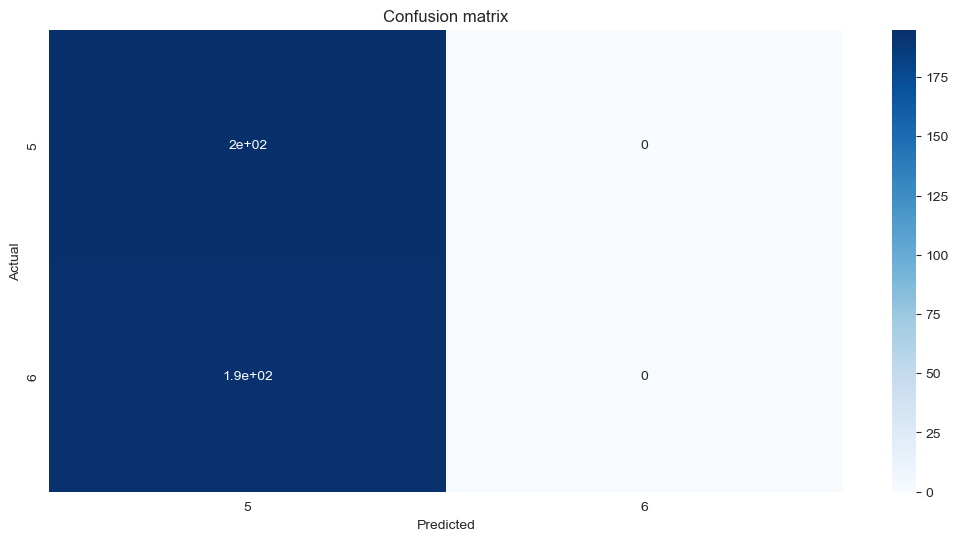

MLP_pca16_data_csp15
              precision    recall  f1-score   support

           5     0.5013    1.0000    0.6678       195
           6     0.0000    0.0000    0.0000       194

    accuracy                         0.5013       389
   macro avg     0.2506    0.5000    0.3339       389
weighted avg     0.2513    0.5013    0.3348       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


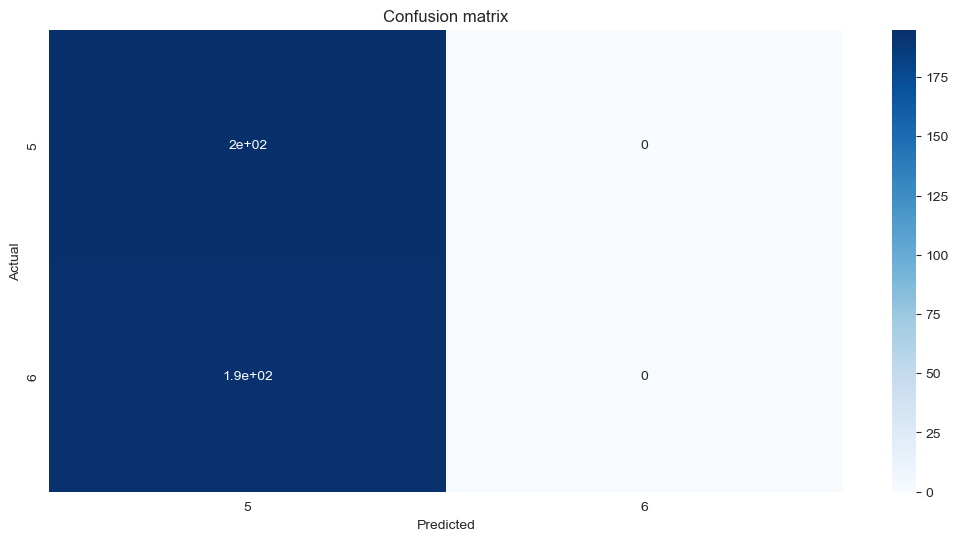

Keras_MLP_csp4
              precision    recall  f1-score   support

           5     0.7190    0.4462    0.5506       195
           6     0.5970    0.8247    0.6926       194

    accuracy                         0.6350       389
   macro avg     0.6580    0.6354    0.6216       389
weighted avg     0.6582    0.6350    0.6215       389



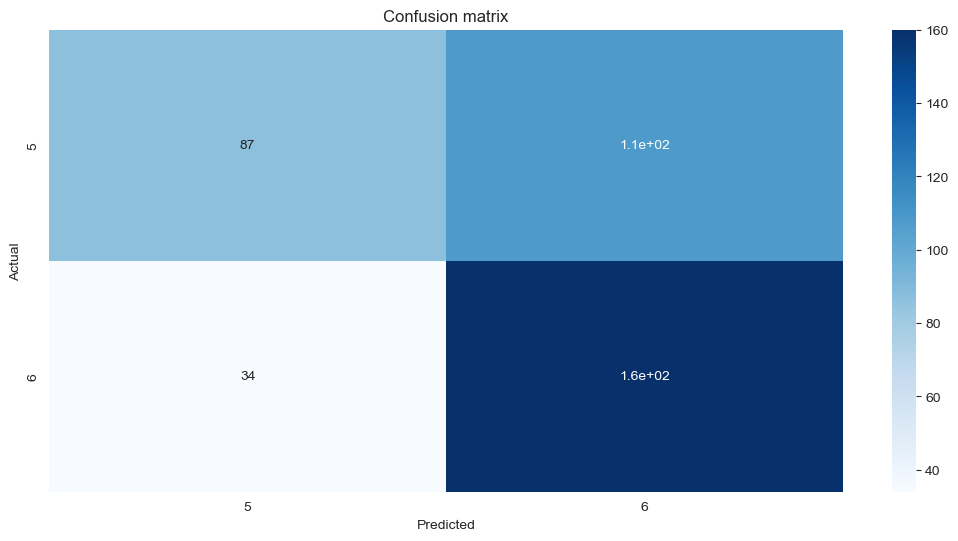

Keras_MLP_csp15
              precision    recall  f1-score   support

           5     0.6892    0.2615    0.3792       195
           6     0.5429    0.8814    0.6719       194

    accuracy                         0.5707       389
   macro avg     0.6160    0.5715    0.5255       389
weighted avg     0.6162    0.5707    0.5252       389



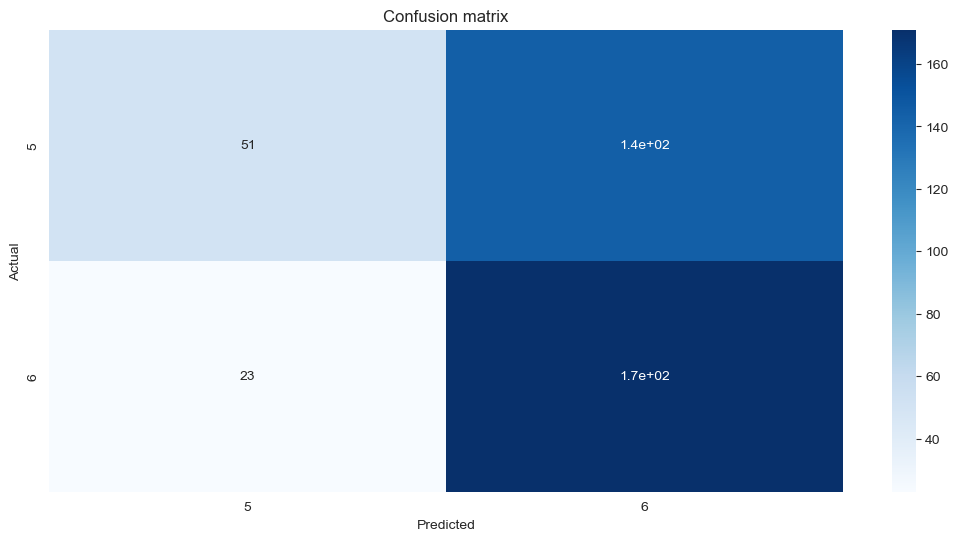

Keras_MLP_pca12_channel_csp4
              precision    recall  f1-score   support

           5     0.7092    0.5128    0.5952       195
           6     0.6169    0.7887    0.6923       194

    accuracy                         0.6504       389
   macro avg     0.6631    0.6507    0.6438       389
weighted avg     0.6632    0.6504    0.6436       389



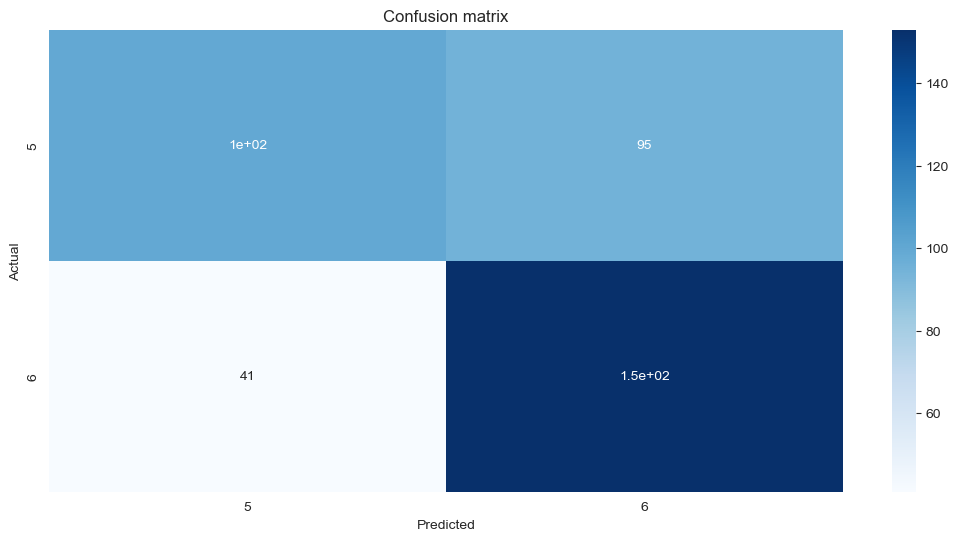

Keras_MLP_pca12_channel_csp15
              precision    recall  f1-score   support

           5     0.7071    0.5077    0.5910       195
           6     0.6145    0.7887    0.6907       194

    accuracy                         0.6478       389
   macro avg     0.6608    0.6482    0.6409       389
weighted avg     0.6609    0.6478    0.6408       389



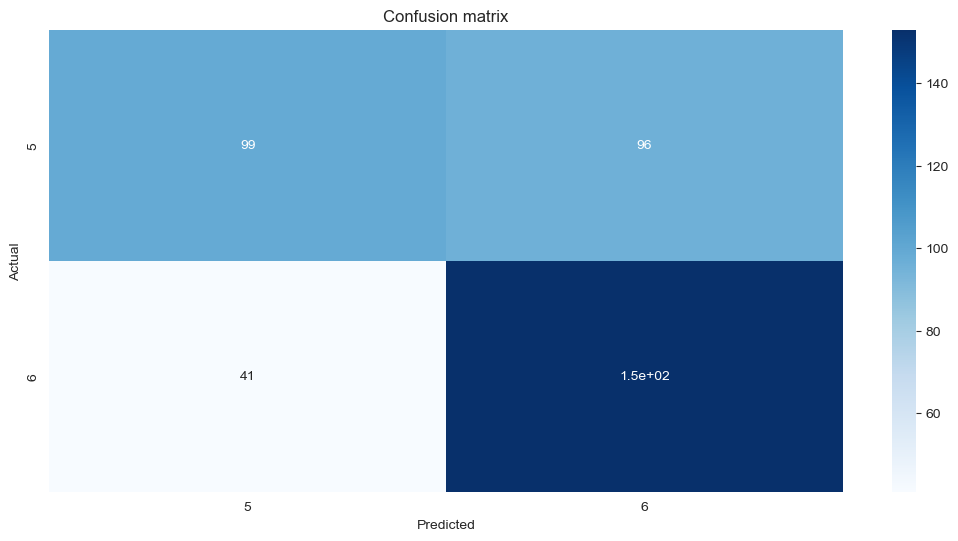

Keras_MLP_pca16_data_csp4
              precision    recall  f1-score   support

           5     0.5053    0.2462    0.3310       195
           6     0.5000    0.7577    0.6025       194

    accuracy                         0.5013       389
   macro avg     0.5026    0.5019    0.4667       389
weighted avg     0.5026    0.5013    0.4664       389



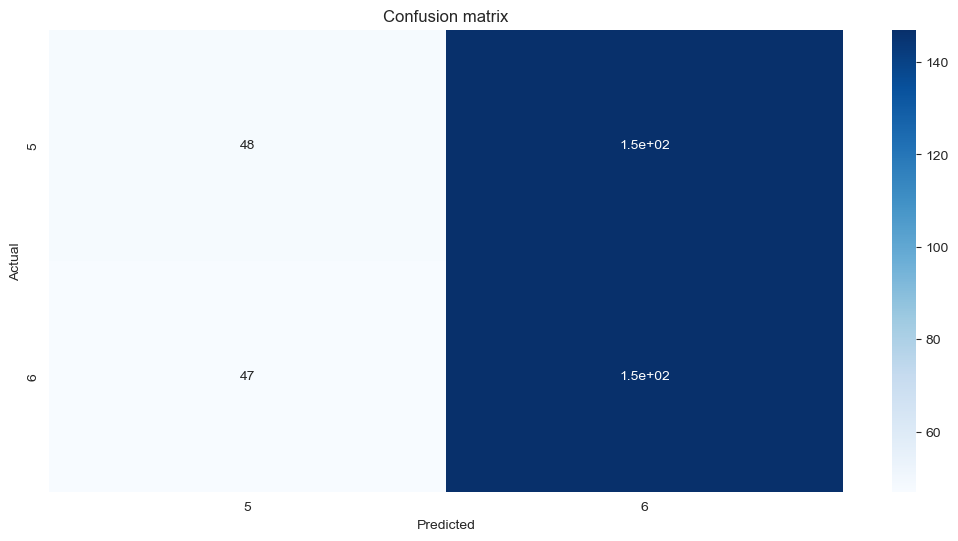

Keras_MLP_pca16_data_csp15
              precision    recall  f1-score   support

           5     0.5355    0.4256    0.4743       195
           6     0.5214    0.6289    0.5701       194

    accuracy                         0.5270       389
   macro avg     0.5284    0.5273    0.5222       389
weighted avg     0.5284    0.5270    0.5221       389



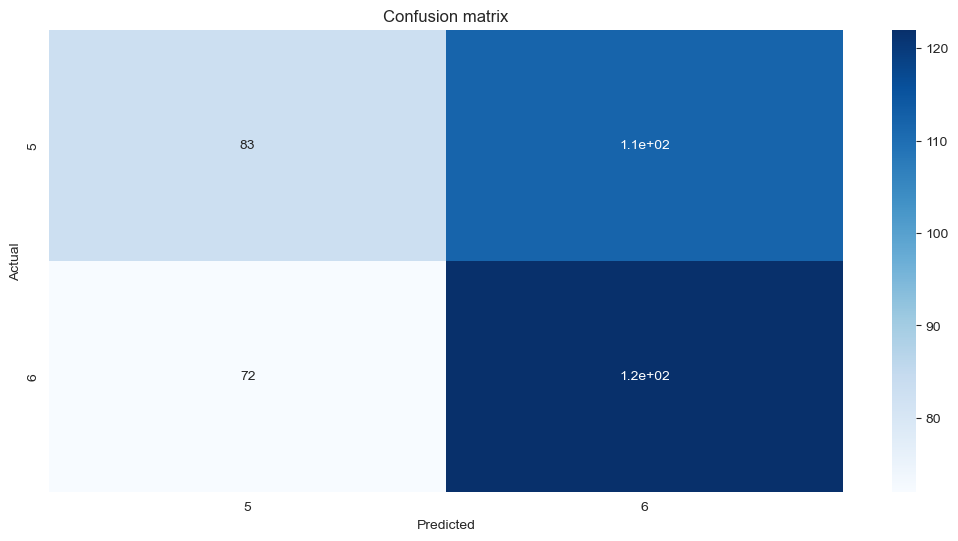

lda_pca12_channel
              precision    recall  f1-score   support

           5     0.4794    0.4769    0.4781       195
           6     0.4769    0.4794    0.4781       194

    accuracy                         0.4781       389
   macro avg     0.4782    0.4782    0.4781       389
weighted avg     0.4782    0.4781    0.4781       389



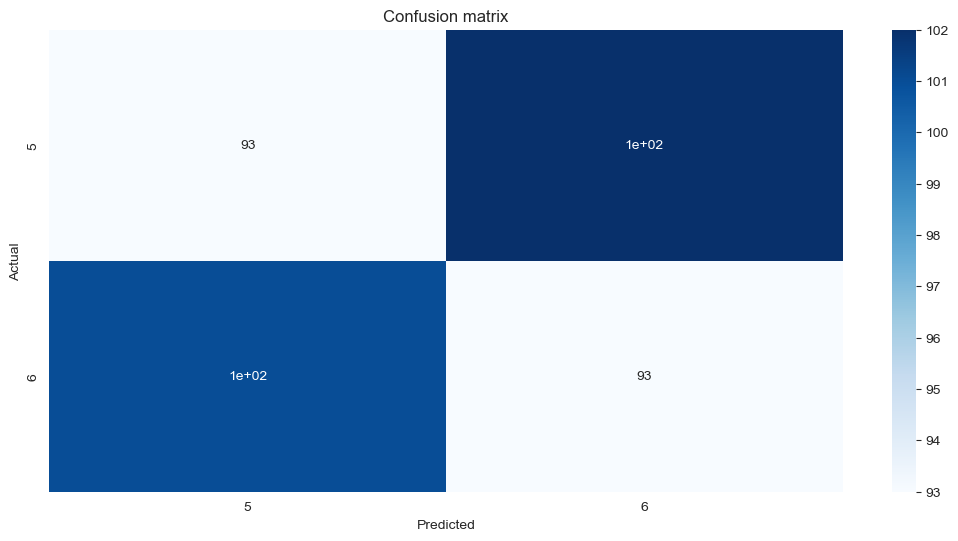

lda_pca16_data
              precision    recall  f1-score   support

           5     0.4798    0.4872    0.4835       195
           6     0.4764    0.4691    0.4727       194

    accuracy                         0.4781       389
   macro avg     0.4781    0.4781    0.4781       389
weighted avg     0.4781    0.4781    0.4781       389



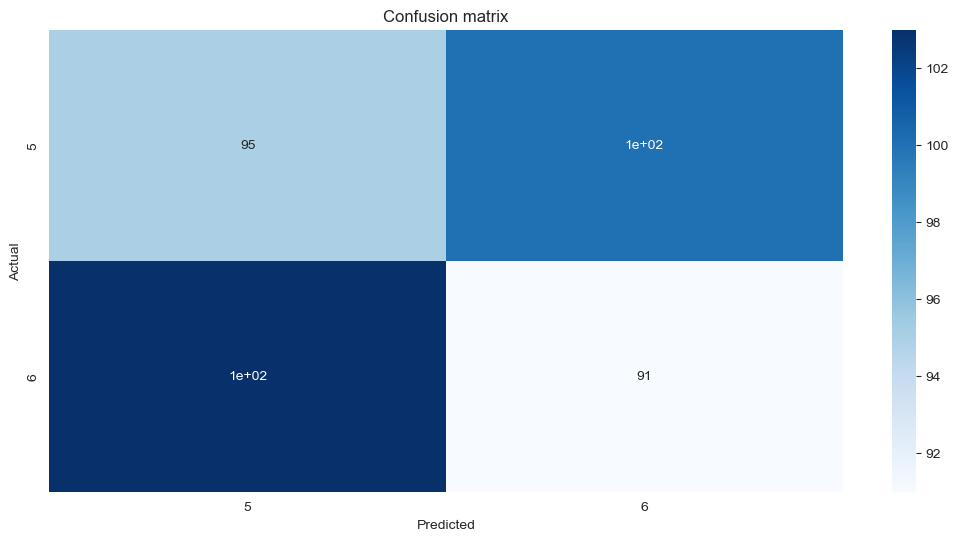

mnbc_pca12_channel
              precision    recall  f1-score   support

           5     0.4811    0.4564    0.4684       195
           6     0.4804    0.5052    0.4925       194

    accuracy                         0.4807       389
   macro avg     0.4807    0.4808    0.4804       389
weighted avg     0.4807    0.4807    0.4804       389



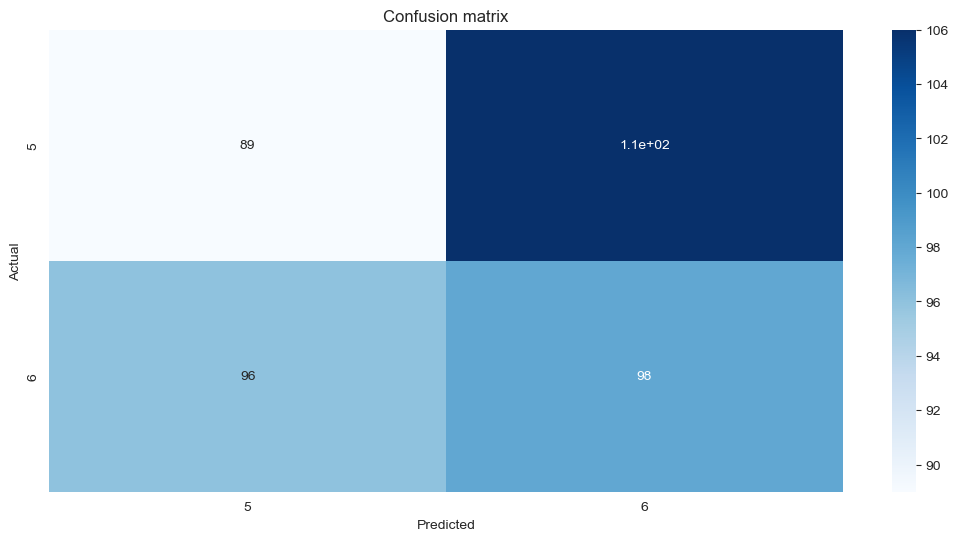

mnbc_pca16_data
              precision    recall  f1-score   support

           5     0.4797    0.3641    0.4140       195
           6     0.4855    0.6031    0.5379       194

    accuracy                         0.4833       389
   macro avg     0.4826    0.4836    0.4760       389
weighted avg     0.4826    0.4833    0.4758       389



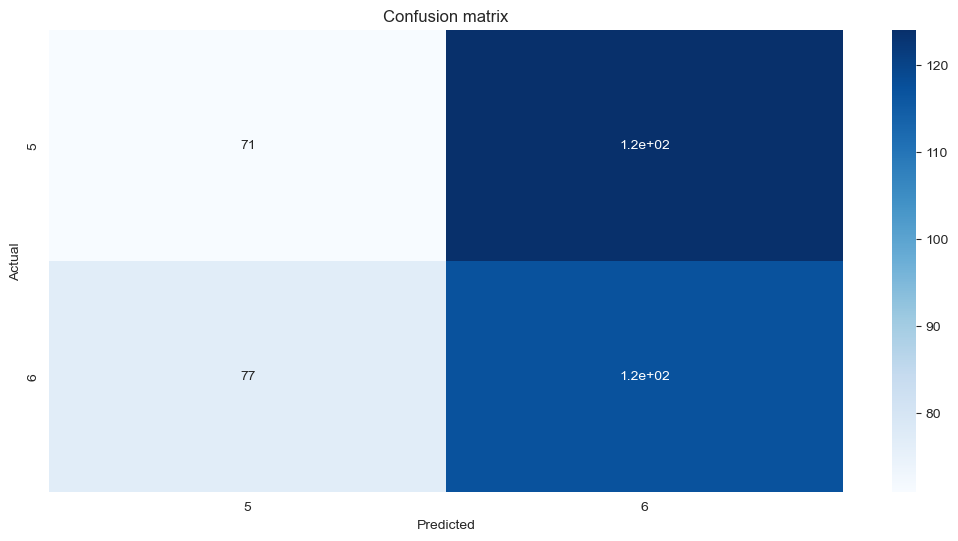

MLP_pca12_channel
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


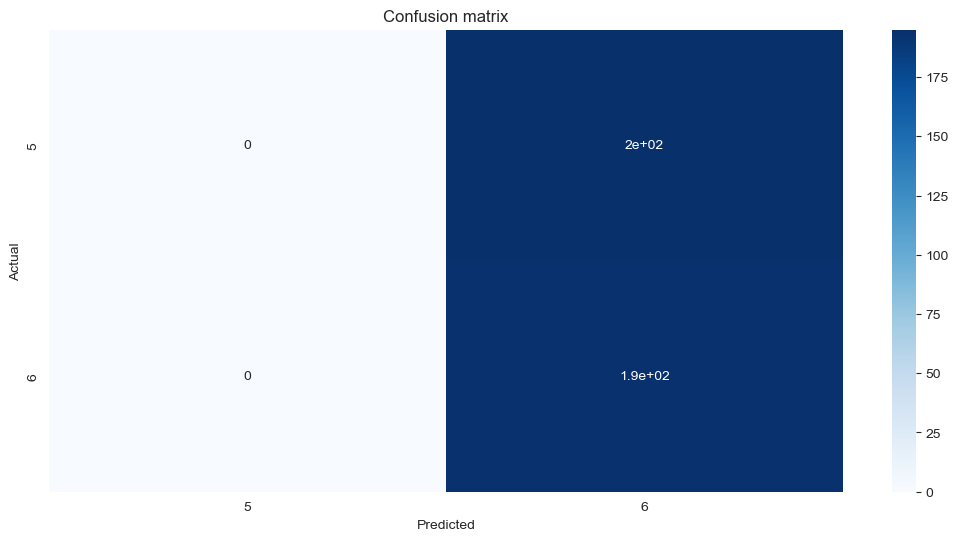

MLP_pca16_data
              precision    recall  f1-score   support

           5     0.5013    1.0000    0.6678       195
           6     0.0000    0.0000    0.0000       194

    accuracy                         0.5013       389
   macro avg     0.2506    0.5000    0.3339       389
weighted avg     0.2513    0.5013    0.3348       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


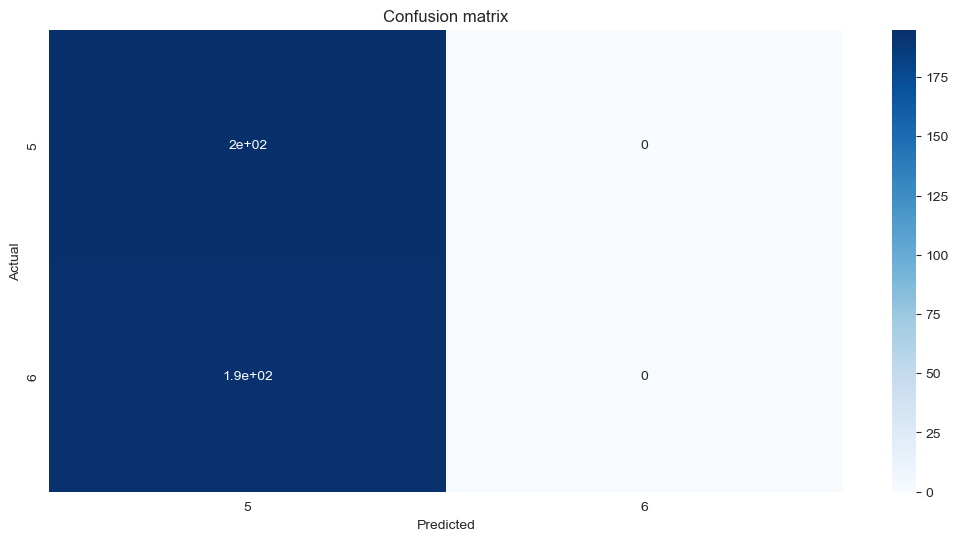

Keras_MLP_pca12_channel
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


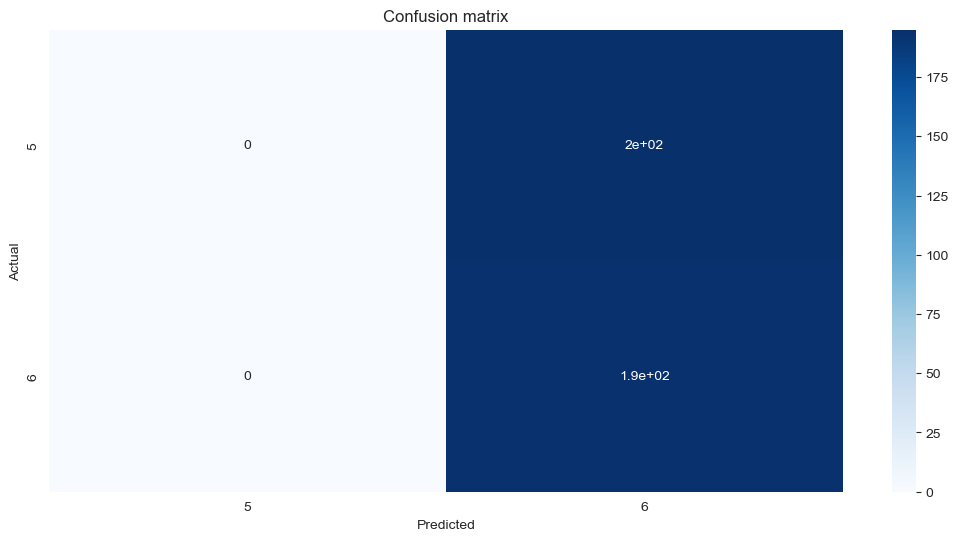

Keras_MLP_pca16_data
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


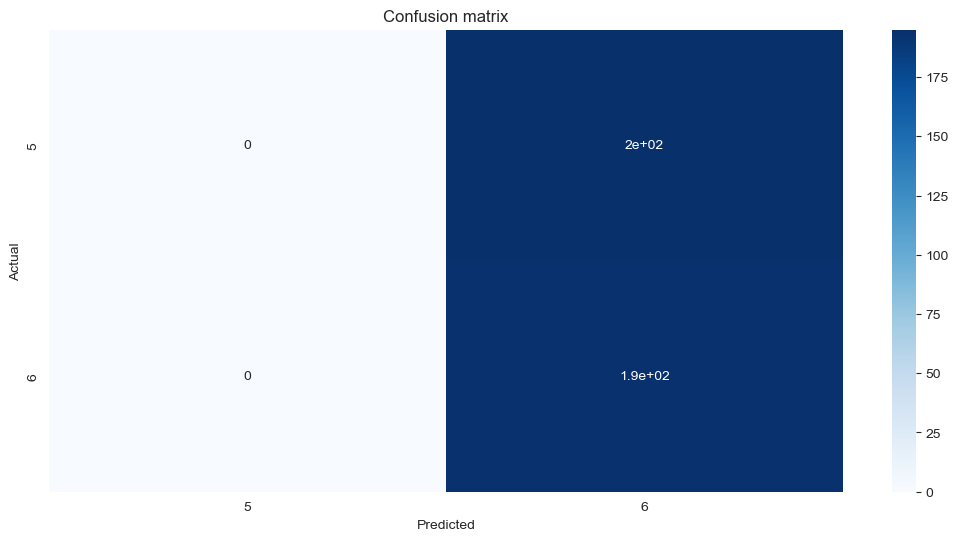

In [179]:
for pipe in Pipes:
    print(pipe.name)
    pipeline = pipe.create_pipeline()
    f1,acc = display_results(pd.DataFrame(y_val)[0],pipeline.predict(pipe.processed_X_val))


In [170]:
len(y_val)

389

In [171]:
np.sum(y_val)

2139

In [172]:
1347-673

674

In [173]:
674/1347


0.5003711952487008

In [174]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

In [175]:
pipe.processed_X_val[:, n : (n + w_length)]

array([[ 0.000002, -0.000005, -0.000005, ..., -0.000025, -0.00003 ,
        -0.000033],
       [-0.000018, -0.000019, -0.000023, ..., -0.000017, -0.000017,
        -0.000016],
       [-0.000028, -0.000022, -0.000023, ..., -0.000007, -0.000017,
        -0.000015],
       ...,
       [-0.000003, -0.000035, -0.000031, ..., -0.000037, -0.000062,
        -0.000054],
       [-0.000056, -0.000063, -0.000071, ...,  0.000043, -0.000007,
         0.000013],
       [-0.000051, -0.000043, -0.000057, ..., -0.000011, -0.000031,
        -0.000029]])

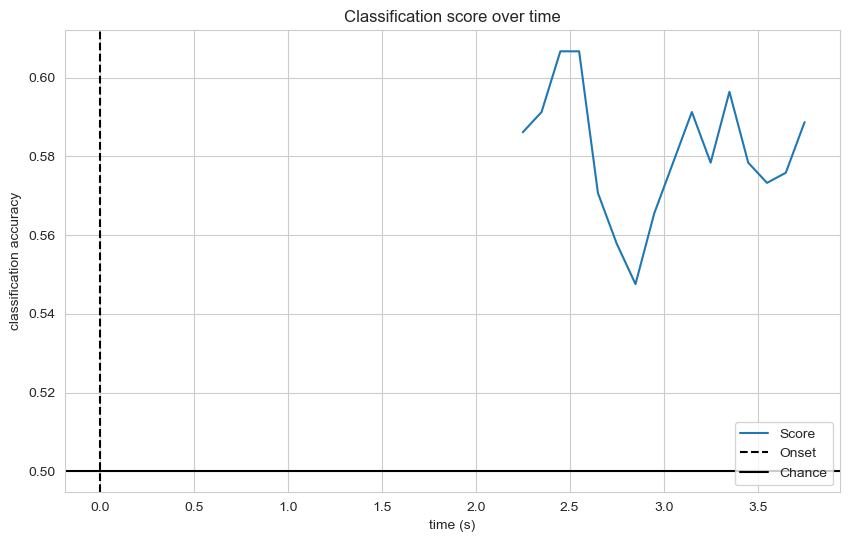

In [176]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data_train.shape[2] - w_length, w_step)

scores_windows = []


# running classifier: test classifier on sliding window
score_this_window = []
for n in w_start:
    transform_list = []
    for event in X_val[:, :, n : (n + w_length)]:
        transform_list.append(pca12_channel.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    X_val_windoed_csp15 = pca12_channel_csp15.transform(transform_list.T)
    score_this_window.append(results_val["lda_pca12_channel_csp15"].score(X_val_windoed_csp15, y_val))
scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs_train.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()